In [6]:
from crime_util import *

In [7]:
import warnings

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data

## Import

I originally built my models from Florida crime data (2017), and will use crime data from Michigan, North Carolina and Ohio to validate the models.

In [8]:
(florida, michigan, nc, ohio) = read_data()

In [9]:
florida.population.describe()

count     255.000
mean    18254.416
std     19431.924
min        92.000
25%      3620.000
50%     10679.000
75%     24929.500
max     79918.000
Name: population, dtype: float64

## Transform

I previously conducted [research](https://github.com/mkm29/DataScience/blob/master/thinkful/unit/2/4/challenge_crime_regression.ipynb) into optimal feature engineering, so I am simply going to use only the transformations that I ended up using in my models.

In [10]:
florida = transform_data(florida)
michigan = transform_data(michigan)
nc = transform_data(nc)
ohio = transform_data(ohio)

In [11]:
# Property crime is not linear with population. It starts off linear, however at a certain point
# it begind to "flatten" out, so we Box-cox transformed the property crime variable
# (those cases where property crime is 0 we added 1)
# add Box-Cox property crime
florida, florida_bc_lambda = boxcox_transform(florida)
michigan, michigan_bc_lambda = boxcox_transform(michigan)
nc, nc_bc_lambda = boxcox_transform(nc)
ohio, ohio_bc_lambda = boxcox_transform(ohio)

print("Box-Cox Lambda's\n******************")
print("Florida: {:.4f}".format(florida_bc_lambda))
print("Michigan: {:.4f}".format(michigan_bc_lambda))
print("North Carolina: {:.4f}".format(nc_bc_lambda))
print("Ohio: {:.4f}".format(ohio_bc_lambda))

Box-Cox Lambda's
******************
Florida: 0.1587
Michigan: 0.0884
North Carolina: 0.0747
Ohio: 0.0757


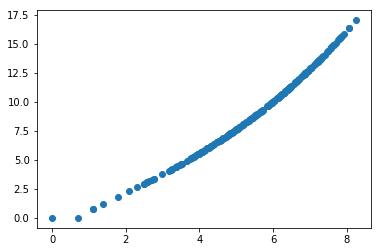

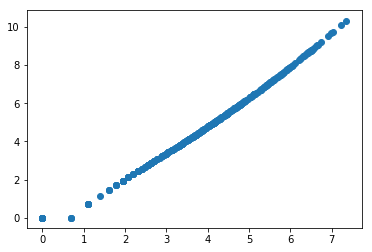

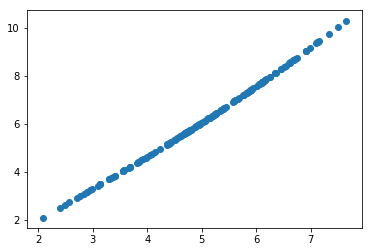

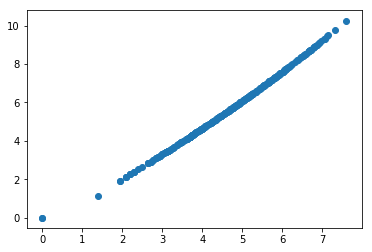

In [19]:
plt.scatter(florida["property_crime_log"], florida["property_crime_bc"])
plt.show()
plt.scatter(michigan["property_crime_log"], michigan["property_crime_bc"])
plt.show()
plt.scatter(nc["property_crime_log"], nc["property_crime_bc"])
plt.show()
plt.scatter(ohio["property_crime_log"], ohio["property_crime_bc"])
plt.show()

## Split

Split each state's data into a train and test set.

In [20]:
florida_train, florida_test = split(florida)
michigan_train, michigan_test = split(michigan)
nc_train, nc_test = split(nc)
ohio_train, ohio_test = split(ohio)

# Model

For this exercise, we are simply going to use model 3 from the previous exercise:

\begin{equation}\label{eq:}
PropertyCrime_{BoxCox} = 0.1328*Population_{log} + 0.5590*Robbery_{has} + 0.3989*Population_{Medium} - 0.1726*Robbery_{log} + 0.4324*\sqrt[3]{Burglary} + 0.8481*\sqrt[3]{Larceny} + 0.2094*VehicleTheft
\end{equation}


In [21]:
model_florida_train, model_florida_test = build_model(florida_train, florida_test)

-----
TRAIN
-----
                             OLS Regression Results                            
Dep. Variable:      property_crime_bc   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     2843.
Date:                Sun, 16 Dec 2018   Prob (F-statistic):          1.52e-172
Time:                        14:35:00   Log-Likelihood:                -64.272
No. Observations:                 178   AIC:                             144.5
Df Residuals:                     170   BIC:                             170.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Interce

In [22]:
model_michigan_train, model_michigan_test = build_model(michigan_train, michigan_test)

-----
TRAIN
-----
                             OLS Regression Results                            
Dep. Variable:      property_crime_bc   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1623.
Date:                Sun, 16 Dec 2018   Prob (F-statistic):          1.11e-208
Time:                        14:35:11   Log-Likelihood:                -69.424
No. Observations:                 265   AIC:                             154.8
Df Residuals:                     257   BIC:                             183.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Interce

*So for the state of Michigan, the second population group is less important on predicting property crime than Florida.*

In [23]:
model_nc_train, model_nc_test = build_model(nc_train, nc_test)

-----
TRAIN
-----
                             OLS Regression Results                            
Dep. Variable:      property_crime_bc   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     723.2
Date:                Sun, 16 Dec 2018   Prob (F-statistic):           7.30e-89
Time:                        14:35:35   Log-Likelihood:                -4.6175
No. Observations:                 118   AIC:                             25.23
Df Residuals:                     110   BIC:                             47.40
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Interce

In [24]:
model_ohio_train, model_ohio_test = build_model(ohio_train, ohio_test)

-----
TRAIN
-----
                             OLS Regression Results                            
Dep. Variable:      property_crime_bc   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1076.
Date:                Sun, 16 Dec 2018   Prob (F-statistic):          4.25e-169
Time:                        14:35:51   Log-Likelihood:                -73.730
No. Observations:                 233   AIC:                             163.5
Df Residuals:                     225   BIC:                             191.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Interce

*For the state of Ohio, population groups 2 and 5 are not statistically significant for this model, as is population log.*

In [25]:
florida["residuals_train"] = evaluate_model(model_florida_train, florida_train, florida_bc_lambda, "Florida (Train)")
florida["residuals_test"] = evaluate_model(model_florida_test, florida_test, florida_bc_lambda, "Florida (Test)")

Florida (Train)
-------------------------------------------------------------

[0.98802228 0.99355375 0.98685684 0.99299431 0.9918634 ]
cv average is = 99.07%
Mean Residual: -15.832161302097354
RMSE: 117.39055717336542
Average Error: 49.873277619039975

Florida (Test)
-------------------------------------------------------------

[0.96627775 0.98187414 0.94319806 0.9875762  0.97108743]
cv average is = 97.00%
Mean Residual: -16.305567326825862
RMSE: 163.15553195825035
Average Error: 50.26135044953447



In [26]:
michigan["residuals_train"] = evaluate_model(model_michigan_train, michigan_train, michigan_bc_lambda, "Michigan (Train)")
michigan["residuals_test"] = evaluate_model(model_michigan_test, michigan_test, michigan_bc_lambda, "Michigan (Test)")

Michigan (Train)
-------------------------------------------------------------

[0.97712176 0.97798051 0.95496192 0.97324833 0.98320281]
cv average is = 97.33%
Mean Residual: -12.6315505020503
RMSE: 101.93706116052121
Average Error: 27.565430780597712

Michigan (Test)
-------------------------------------------------------------

[0.9597424  0.93340758 0.98021523 0.98062448 0.97121825]
cv average is = 96.50%
Mean Residual: -25.70657590486674
RMSE: 200.75913024111986
Average Error: 42.47778172095505



In [27]:
nc["residuals_train"] = evaluate_model(model_nc_train, nc_train, nc_bc_lambda, "North Carolina (Train)")
nc["residuals_test"] = evaluate_model(model_nc_test, nc_test, nc_bc_lambda, "North Carolina (Test)")

North Carolina (Train)
-------------------------------------------------------------

[0.98276256 0.95810304 0.97650167 0.97387176 0.97393562]
cv average is = 97.30%
Mean Residual: -11.880686203115351
RMSE: 95.29617943949341
Average Error: 36.31838479084797

North Carolina (Test)
-------------------------------------------------------------

[0.98179468 0.94522469 0.98337091 0.97540822 0.96959419]
cv average is = 97.11%
Mean Residual: -14.416297161797587
RMSE: 118.31340555212634
Average Error: 55.2514883278376



In [28]:
ohio["residuals_train"] = evaluate_model(model_ohio_train, ohio_train, ohio_bc_lambda, "Ohio (Train)")
ohio["residuals_test"] = evaluate_model(model_ohio_test, ohio_test, ohio_bc_lambda, "Ohio (Test)")

Ohio (Train)
-------------------------------------------------------------

[0.96664621 0.95729597 0.98096973 0.95380925 0.98014758]
cv average is = 96.78%
Mean Residual: -25.003103025071226
RMSE: 167.1677011672147
Average Error: 53.661805620093524

Ohio (Test)
-------------------------------------------------------------

[0.95505202 0.94616295 0.96585903 0.95475216 0.99101635]
cv average is = 96.26%
Mean Residual: -20.210918944062012
RMSE: 154.94913987646294
Average Error: 39.11477888948355



## Residual Analysis

### Florida

In [29]:
florida_residuals = np.concatenate((florida["residuals_train"].dropna().values, florida["residuals_test"].dropna().values))
florida_percent_off = (florida["property_crime_2"] - florida_residuals) / florida["property_crime_2"]
np.abs(florida_percent_off).sum() / florida_percent_off.shape[0]

1.2266756762021922

In [30]:
(florida_residuals<0).sum()/florida_residuals.shape[0]

0.4823529411764706

### Michigan

In [31]:
michigan_residuals = np.concatenate((michigan["residuals_train"].dropna().values, michigan["residuals_test"].dropna().values ))
michigan_percent_off = (michigan["property_crime_2"] - michigan_residuals) / michigan["property_crime_2"]
np.abs(michigan_percent_off).sum() / michigan_percent_off.shape[0]

1.757007485059597

In [32]:
(michigan_residuals<0).sum() / michigan_residuals.shape[0]

0.40897097625329815

### North Carolina

In [33]:
nc_residuals = np.concatenate((nc["residuals_train"].dropna().values, nc["residuals_test"].dropna().values))
nc_percent_off = (nc["property_crime_2"] - nc_residuals) / nc["property_crime_2"]
np.abs(nc_percent_off).sum() / nc_percent_off.shape[0]

1.0666514134217582

In [34]:
(nc_residuals<0).sum()/nc_residuals.shape[0]

0.38461538461538464

### Ohio

In [35]:
ohio_residuals = np.concatenate((ohio["residuals_train"].dropna().values, ohio["residuals_test"].dropna().values))
ohio_percent_off = (ohio["property_crime_2"] - ohio_residuals) / ohio["property_crime_2"]
np.abs(ohio_percent_off).sum() / ohio_percent_off.shape[0]

5.426191498820303

In [36]:
(ohio_residuals<0).sum()/ohio_residuals.shape[0]

0.37537537537537535

# Conclusion

By itself, the model that I propose for predicting property crime in Florida (2017) has a RMSE of 122.5 (on the test set), the same model on Michigan crime data has a RMSE of 225.1, 161.2 for North Carolina and 184.7 on Ohio data. There are obvious population dynamic differences among the states (as shown by the insignificance of population groups in Michigan and Ohio). Therefore, different models should be used for these states. 

According to the total percent each prediction is to the observed values, the model appears to work best on North Carolina data, with only about a 6% difference, whereas when using this model to predict Michigan property crimes it is off by 442%.